In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Inception 모듈 정의
def inception_module(x, filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool_proj):
    # 1x1 Conv
    conv_1x1 = layers.Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)

    # 3x3 Conv
    conv_3x3 = layers.Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_3x3 = layers.Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')(conv_3x3)

    # 5x5 Conv
    conv_5x5 = layers.Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_5x5 = layers.Conv2D(filters_5x5, (5, 5), padding='same', activation='relu')(conv_5x5)

    # 3x3 MaxPooling
    pool_proj = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = layers.Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(pool_proj)

    # 병합
    output = layers.concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=-1)

    return output

# GoogleNet 모델 정의
def GoogleNet(input_shape=(32, 32, 3), num_classes=100):
    inputs = layers.Input(shape=input_shape)

    # 초기 Conv 레이어
    x = layers.Conv2D(64, (7, 7), strides=2, padding='same', activation='relu')(inputs)
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Inception 모듈 적용
    x = inception_module(x, 64, 96, 128, 16, 32, 32)
    x = inception_module(x, 128, 128, 192, 32, 96, 64)
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)

    x = inception_module(x, 192, 96, 208, 16, 48, 64)
    x = inception_module(x, 160, 112, 224, 24, 64, 64)
    x = inception_module(x, 128, 128, 256, 24, 64, 64)
    x = inception_module(x, 112, 144, 288, 32, 64, 64)
    x = inception_module(x, 256, 160, 320, 32, 128, 128)
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)

    x = inception_module(x, 256, 160, 320, 32, 128, 128)
    x = inception_module(x, 384, 192, 384, 48, 128, 128)

    # Global Average Pooling 및 출력층
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # 모델 생성
    model = models.Model(inputs, outputs)
    return model

# 모델 학습 및 평가
def train_and_evaluate():
    # CIFAR-100 데이터셋 로드 및 전처리
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0
    y_train = tf.keras.utils.to_categorical(y_train, 100)
    y_test = tf.keras.utils.to_categorical(y_test, 100)

    # GoogleNet 모델 생성
    model = GoogleNet(input_shape=(32, 32, 3), num_classes=100)

    # 모델 컴파일
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Early Stopping 설정 (검증 손실이 5 에폭 동안 개선되지 않으면 학습 중단)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # 데이터 증강 설정
    datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True
    )

    # 모델 학습
    history = model.fit(datagen.flow(x_train, y_train, batch_size=64),
                        epochs=50,
                        validation_data=(x_test, y_test),
                        callbacks=[early_stopping])

    # 모델 평가
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
    print(f"Test accuracy: {test_acc}")

    return model, history

# 모델 학습 및 평가 실행
model, history = train_and_evaluate()


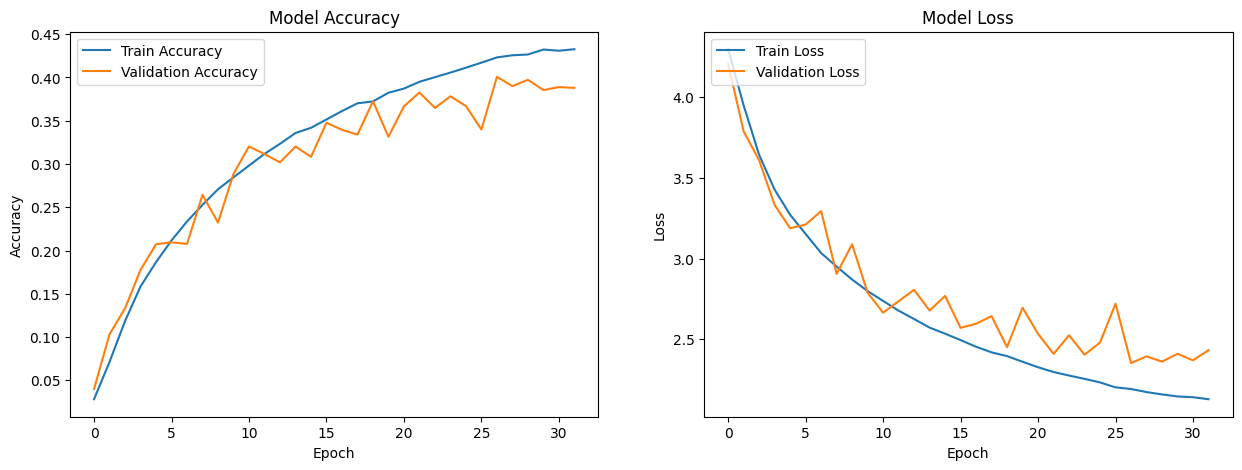

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# 정확도 그래프
axs[0].plot(history.history['accuracy'], label='Train Accuracy')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_title('Model Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(loc='upper left')

# 손실 그래프
axs[1].plot(history.history['loss'], label='Train Loss')
axs[1].plot(history.history['val_loss'], label='Validation Loss')
axs[1].set_title('Model Loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(loc='upper left')

plt.show()